In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

gender_sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('/kaggle/input/titanic/train.csv')
train


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### **Column Descriptions**

**Survived:** Binary. 0 for not survived, 1 for survived.  
**Pclass:** Passenger class on the ship. 1 for first, 2 for second, 3 for third.  
**Name:** Name of the passenger.  
**Sex:** Sex of the passenger.  
**Age:** Age in years of the passenger.  
**SibSp:** Siblings or spouses per passenger.  
**Parch:** Parents or children per passenger.  
**Ticket:** Code of passenger ticket.  
**Fare:** Amount spend on the trip.  
**Cabin:** Cabin number in the ship.  
**Embarked:** Local of boarding. S for Southampton, C for Cherbourg, and Q for Queenstown  

In [2]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## **Previous Analysis**

Let´s take a look at the general analysis of the data. We're gonna generate visualizations based on the main features.

In [3]:
#Preparing a dataset copy for analysis
import matplotlib.pyplot as plt
import seaborn as sns

df_analysis = train.copy()
df_analysis['Condition'] = df_analysis['Survived'].apply(lambda x: 'Survived' if x == 1 else 'Died')
df_analysis['Age'].fillna(int(df_analysis['Age'].mean()), inplace=True)
penguins = sns.load_dataset("penguins")


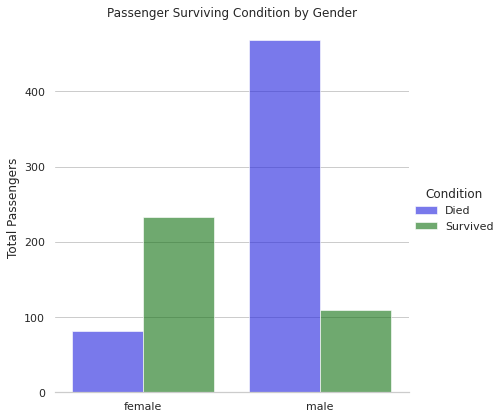

In [4]:
#Survivors Statistics by Gender
sum_data = df_analysis.groupby(["Sex", "Condition"])["PassengerId"].count().reset_index()

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=sum_data, kind="bar",
    x="Sex", y="PassengerId", hue="Condition",
    ci="sd", palette=["blue", "green"], alpha=.6, height=6)
g.despine(left=True)
g.set(title='Passenger Surviving Condition by Gender')
g.set_axis_labels("", "Total Passengers")


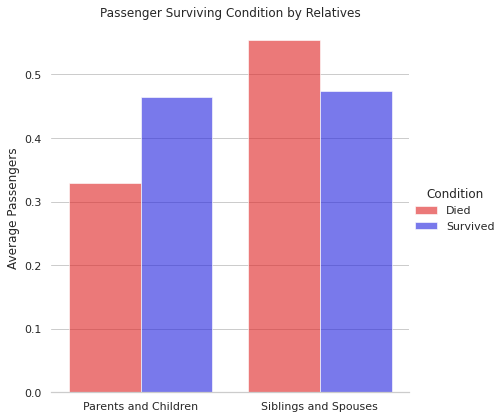

In [5]:
#Surviving Statistics Based on The Relatives
sum_data_parch = df_analysis.groupby(["Condition"])["Parch"].mean().reset_index()
sum_data_parch.rename(columns={'Parch': 'Mean'}, inplace=True)
sum_data_parch['Type'] = "Parents and Children"
sum_data_sbsp = df_analysis.groupby(["Condition"])["SibSp"].mean().reset_index()
sum_data_sbsp.rename(columns={'SibSp': 'Mean'}, inplace=True)
sum_data_sbsp['Type'] = "Siblings and Spouses"
sum_data = pd.concat([sum_data_parch, sum_data_sbsp])
sum_data
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=sum_data, kind="bar",
    x="Type", y="Mean", hue="Condition",
    ci="sd", palette=["red", "blue"], alpha=.6, height=6)
g.despine(left=True)
g.set(title='Passenger Surviving Condition by Relatives')
g.set_axis_labels("", "Average Passengers")

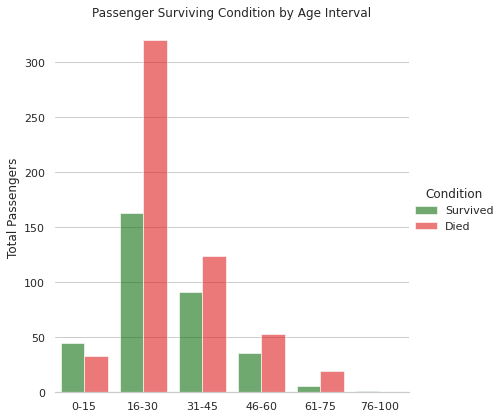

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

labels_age = ['0-15', '16-30', '31-45', '46-60', '61-75', '76-100']
df_analysis["Age_Interval"] = pd.cut(df_analysis["Age"], bins=[0, 15, 30, 45, 60, 75, 100], right=False, labels=labels_age)
age_analysis_survived = df_analysis[df_analysis['Survived'] == 1].groupby(["Age_Interval"])["Survived"].count().reset_index()
age_analysis_survived.rename(columns={'Survived': 'Count'}, inplace=True)
age_analysis_died = df_analysis[df_analysis['Survived'] == 0].groupby(["Age_Interval"])["Survived"].count().reset_index()
age_analysis_died.rename(columns={'Survived': 'Count'}, inplace=True)
age_analysis = pd.concat([age_analysis_survived, age_analysis_died], axis=0)
age_analysis['Condition'] = (['Survived'] * 6) + (['Died'] * 6)
age_analysis

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=age_analysis, kind="bar",
    x="Age_Interval", y="Count", hue="Condition",
    ci="sd", palette=["green", "red"], alpha=.6, height=6)
g.despine(left=True)
g.set(title='Passenger Surviving Condition by Age Interval')
g.set_axis_labels("", "Total Passengers")



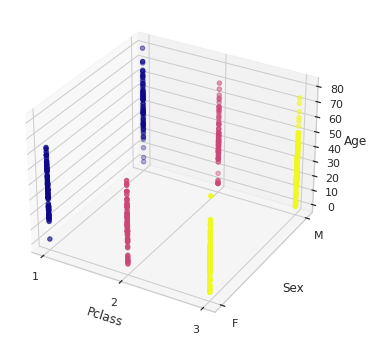

In [7]:
import re, random

from pylab import *
from matplotlib.pyplot import show, draw, figure, cm

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection="3d")

train['SBin'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)

ax.scatter(train.Pclass, train.SBin, train.Age, c=train.Pclass, marker='o', cmap='plasma')
ax.set_xlabel('Pclass')
ax.set_ylabel('Sex')
ax.set_zlabel('Age')

ax.set_yticks([0, 1])
ax.set_yticklabels(['F', 'M'])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['1', '2', '3'])
plt.show()



## **Cleaning and Encoding**

The columns 'Name', 'Ticket', 'Cabin' and 'Embarked' don't necessarily presents great contribution to the prediction, since they are not atributes to configure advantages or disvantages of survival. So, we delete this fields from the dataset.    

Afterwords, once the only field containing relevant missing values is "Age", let's fill this missing data with the average age of the total.

In [8]:
def cleaning_missing(df_pure):
    df = df_pure.copy()
    df.Age.fillna(int(df.Age.mean()), inplace=True)
    df.Fare.fillna(df.Fare.mean(), inplace=True)
    df.drop(columns=['Name','Ticket', 'Cabin', 'Embarked'], inplace=True)
    if 'Survived' in list(df.columns):
        return df.drop(columns=['Survived']), pd.DataFrame(df['Survived']).values.ravel()
    else:
        return df, None

Now, we can start the encode process with the features. For qualitative fields, the appropriate method is the Dummy conversion. Let's create new variables for each category data.    

For that, let's use two Scikit Learn library tools called OneHotEncoder, for encode fields in binaries, and ColumnTransformer, for column creations.

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def encoding_data(df_cleaned):
    pssg_id = list(df_cleaned['PassengerId'])
    df_cleaned.drop(columns=['PassengerId'], inplace=True)
    df_coded = pd.DataFrame(ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0, 1])], remainder='passthrough')
                            .fit_transform(df_cleaned))
    df_coded.drop(columns=4, axis=1, inplace=True) # deleting the extra column for Sex. Now, 1 is Female, 0 is Male.
    df_coded['Id'] = pssg_id
    return df_coded

Now, let's scalling the features, so the average will be next to 0 and standard deviation next to 1. It will garant more fidelity to the model.

In [10]:
from sklearn.preprocessing import StandardScaler

def scalling_df(df_coded):
    df_coded_esc = pd.DataFrame(StandardScaler().fit_transform(df_coded))
    return df_coded_esc

So, it's time to define the training and test procedures for all types of models we'll use.

In [11]:
def metrics_validation(model, trainX, trainY):    
    type_metrics = ['accuracy', 'precision_macro', 'recall_macro']
    metrics = cross_validate(model, trainX, trainY, cv=20, scoring=type_metrics)
    dict_metrics = {met: metrics[met] for met in metrics}
    # fit_time, score_time, test_accuracy, test_precision_macro, test_recall_macro

    print(f' -- Accuracy -- Avg: {np.mean(dict_metrics["test_accuracy"])} Std: {np.std(dict_metrics["test_accuracy"])}')
    print(f' -- Fit -- Avg: {np.mean(dict_metrics["fit_time"])} Std: {np.std(dict_metrics["fit_time"])}')
    print(f' -- Score -- Avg: {np.mean(dict_metrics["score_time"])} Std: {np.std(dict_metrics["score_time"])}')
    print(f' -- Recall -- Avg: {np.mean(dict_metrics["test_recall_macro"])} Std: {np.std(dict_metrics["test_recall_macro"])}')

    return dict_metrics

In [12]:
def data_preparation(data):
    data_clean, dataY = cleaning_missing(data)
    data_encoded = encoding_data(data_clean)
    dataX = scalling_df(data_encoded.iloc[: , :-1]).to_numpy()
    
    return dataX, dataY

In [13]:
def training_validation(model, data):
    trainX, trainY = data_preparation(data)

    dict_metrics = metrics_validation(model, trainX, trainY)
    
    fig = plt.figure(figsize=(12,5))
    sns.set(rc={'axes.facecolor':'white'})
    ax = fig.add_subplot()
    ax.set_ylim(0.5, 1)
    sns.lineplot(data = pd.DataFrame(dict_metrics))

    
    return trainX, trainY, dict_metrics

In [14]:
def test_prediction(model, data):
    data['Survived'] = ''
    df_for_test, _ = cleaning_missing(data)
    df_t_encoded = encoding_data(df_for_test)
    testX = scalling_df(df_t_encoded.iloc[: , :]).to_numpy()

    prediction = pd.DataFrame({'PassengerId': df_t_encoded.Id})
    prediction['Survived'] = model.predict(testX)
    return prediction

## **Training the Model Naive Bayes**

Let's create the model Naive Bayes that will be trained and tested with the dataset. After, we will train this model with the cross validate method, using the Scikit Learn library.

In [15]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [16]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


 -- Accuracy -- Avg: 0.7889646464646466 Std: 0.04101472675061371
 -- Fit -- Avg: 0.0011931657791137695 Std: 8.509751606815112e-05
 -- Score -- Avg: 0.002366495132446289 Std: 0.00017029704549229865
 -- Recall -- Avg: 0.7755466075319016 Std: 0.04320128827463445


GaussianNB()

<Figure size 1080x1440 with 0 Axes>

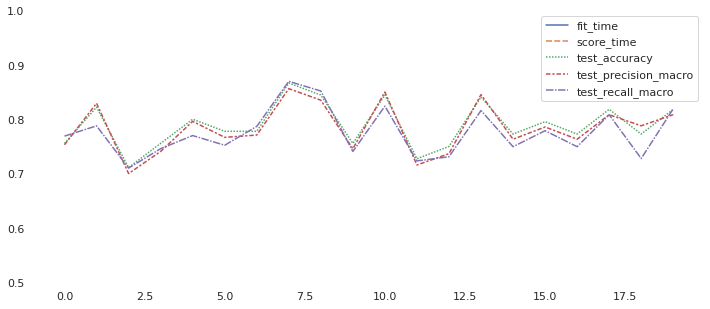

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

metrics_models = dict()

fig = plt.figure(figsize=(15,20))

modelNB = GaussianNB()
trainX, trainY, metrics_models['Bayes'] = training_validation(modelNB, train)
modelNB.fit(trainX, trainY)

## **Training Model SVM**

 -- Accuracy -- Avg: 0.8272474747474747 Std: 0.05301309845977006
 -- Fit -- Avg: 0.02590897083282471 Std: 0.0011023270535928682
 -- Score -- Avg: 0.003614187240600586 Std: 0.00017692057857542938
 -- Recall -- Avg: 0.8044992997198879 Std: 0.062380339660262504


SVC(C=2.0, random_state=1)

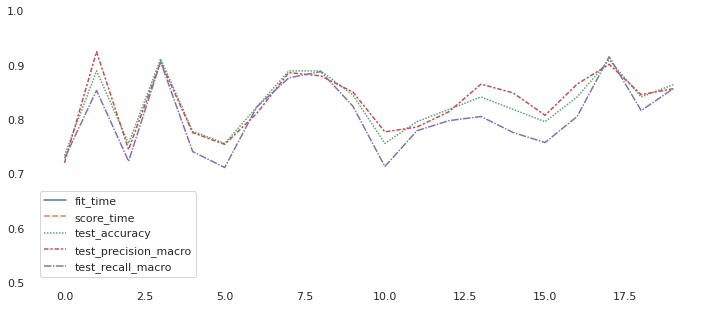

In [18]:
from sklearn.svm import SVC

modelSVM = SVC(C=2.0, gamma='scale', kernel='rbf', random_state=1)
trainX, trainY, metrics_models['SVM'] = training_validation(modelSVM, train)
modelSVM.fit(trainX, trainY)

link: https://medium.com/@msremigio/%C3%A1rvores-de-decis%C3%A3o-decision-trees-4cb6857671b3

## **Training DecisionTree Model**

 -- Accuracy -- Avg: 0.8214646464646466 Std: 0.061764290399999325
 -- Fit -- Avg: 0.001945936679840088 Std: 0.0003339570941741803
 -- Score -- Avg: 0.0021974802017211913 Std: 0.00012918967395998072
 -- Recall -- Avg: 0.8009278711484594 Std: 0.0703983172590269


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=30, random_state=10)

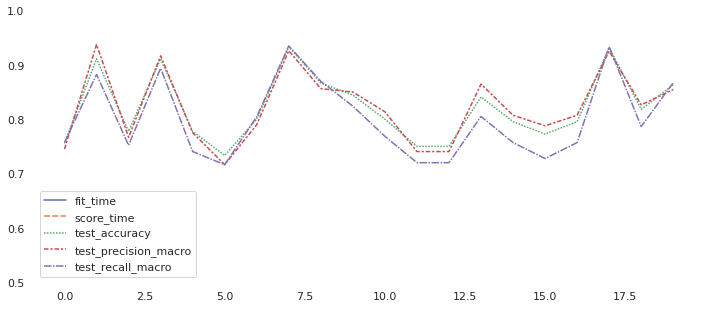

In [19]:
from sklearn.tree import DecisionTreeClassifier as DTC

modelDTC = DTC(max_depth=4, random_state=10, max_leaf_nodes=30)
trainX, trainY, metrics_models['DecisionTree'] = training_validation(modelDTC, train)
modelDTC.fit(trainX, trainY)

## **Training RandomForestModel**

 -- Accuracy -- Avg: 0.8227020202020201 Std: 0.051502146060844516
 -- Fit -- Avg: 0.2692883968353271 Std: 0.007551900560831
 -- Score -- Avg: 0.015254569053649903 Std: 0.0007458863807572721
 -- Recall -- Avg: 0.8066098661686898 Std: 0.06468114773249209


RandomForestClassifier(criterion='entropy', random_state=0)

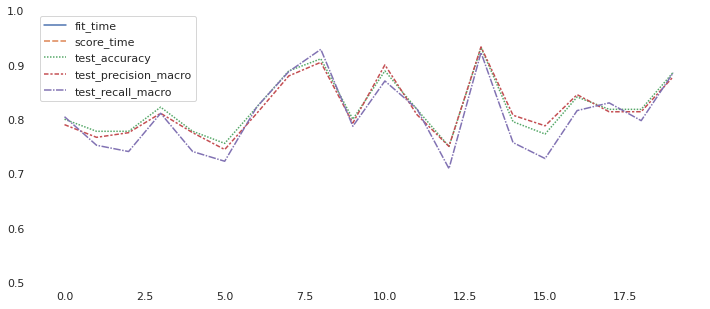

In [20]:
from sklearn.ensemble import RandomForestClassifier as RFC

modelRF = RFC(n_estimators=100, criterion='entropy', random_state=0)
trainX, trainY, metrics_models['RandomForest'] = training_validation(modelRF, train)
modelRF.fit(trainX, trainY)


## **Testing Logistic Regression Model**

 -- Accuracy -- Avg: 0.7957323232323232 Std: 0.041875197493088864
 -- Fit -- Avg: 0.00604398250579834 Std: 0.0015022333998860272
 -- Score -- Avg: 0.002427983283996582 Std: 0.000196029201264226
 -- Recall -- Avg: 0.7788398692810456 Std: 0.047188861682936456


LogisticRegression(max_iter=200, random_state=1)

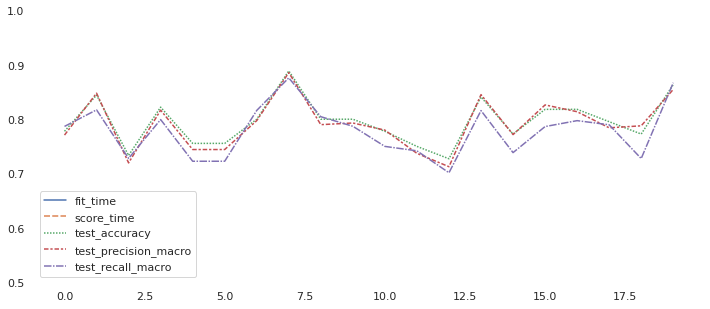

In [21]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression(random_state=1, penalty="l2", max_iter=200)
trainX, trainY, metrics_models['LogisticRegression'] = training_validation(modelLR, train)
modelLR.fit(trainX, trainY)

## **Trainign XGBoost Model**
Decision Tree-based model

 -- Accuracy -- Avg: 0.8372727272727273 Std: 0.04895932608453648
 -- Fit -- Avg: 0.8845568180084229 Std: 0.29040072384574833
 -- Score -- Avg: 0.0068005681037902836 Std: 0.0002976806032536297
 -- Recall -- Avg: 0.8163009648303767 Std: 0.05807338073287647


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, ...)

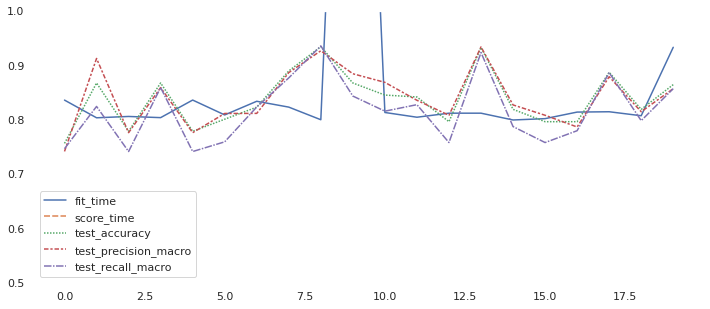

In [22]:
from xgboost import XGBClassifier as xgb

modelXGB = xgb(random_state=3, learning_rate=0.05, max_depth=4, n_estimators=200, objective="binary:logistic")
trainX, trainY, metrics_models['XGBoost'] = training_validation(modelXGB, train)

modelXGB.fit(trainX, trainY)

## **Training Light GBM Model**

Decision Tree-based model

 -- Accuracy -- Avg: 0.835151515151515 Std: 0.058928465312437714
 -- Fit -- Avg: 0.06878188848495484 Std: 0.010374748261113327
 -- Score -- Avg: 0.0032390236854553224 Std: 0.0001671997635815388
 -- Recall -- Avg: 0.815589013383131 Std: 0.07194375800143701


LGBMClassifier(learning_rate=0.05, max_depth=7, num_leaves=150,
               objective='binary')

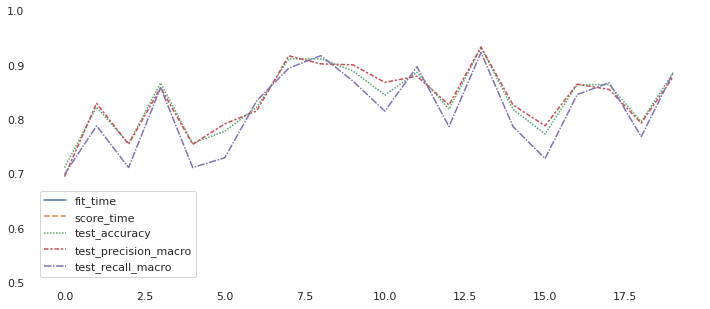

In [23]:
import lightgbm as LGBM

params = {'num_leaves': 150, 'objective': 'binary', 'max_depth': 7, 'learning_rate': .05, 'max_bin': 200}
modelLGBM = LGBM.LGBMClassifier(num_leaves=150, objective='binary', max_depth=7, learning_rate=.05)
trainX, trainY, metrics_models['LightGBM'] = training_validation(modelLGBM, train)

modelLGBM.fit(trainX, trainY)


## **Training CatBoost Model**

Decision Tree-based model, handles categorical data and non structured data.

In [24]:
import catboost as Cat
df_for_train, trainY = cleaning_missing(train)
df_for_train.drop(columns={'Sex'}, inplace=True)

modelCB = Cat.CatBoostClassifier(iterations=1, learning_rate=.05)
metrics_models['CatBoost'] = metrics_validation(modelCB, df_for_train, trainY)


0:	learn: 0.6752756	total: 57.6ms	remaining: 0us
0:	learn: 0.6755232	total: 1.19ms	remaining: 0us
0:	learn: 0.6752402	total: 997us	remaining: 0us
0:	learn: 0.6753224	total: 920us	remaining: 0us
0:	learn: 0.6751987	total: 942us	remaining: 0us
0:	learn: 0.6752100	total: 953us	remaining: 0us
0:	learn: 0.6753756	total: 1.13ms	remaining: 0us
0:	learn: 0.6759211	total: 1ms	remaining: 0us
0:	learn: 0.6753849	total: 999us	remaining: 0us
0:	learn: 0.6751402	total: 969us	remaining: 0us
0:	learn: 0.6749252	total: 920us	remaining: 0us
0:	learn: 0.6752851	total: 1.01ms	remaining: 0us
0:	learn: 0.6769502	total: 917us	remaining: 0us
0:	learn: 0.6753544	total: 719us	remaining: 0us
0:	learn: 0.6754959	total: 941us	remaining: 0us
0:	learn: 0.6753788	total: 954us	remaining: 0us
0:	learn: 0.6757165	total: 943us	remaining: 0us
0:	learn: 0.6755740	total: 952us	remaining: 0us
0:	learn: 0.6752897	total: 942us	remaining: 0us
0:	learn: 0.6757989	total: 988us	remaining: 0us
 -- Accuracy -- Avg: 0.799090909090909

## Comparing Models

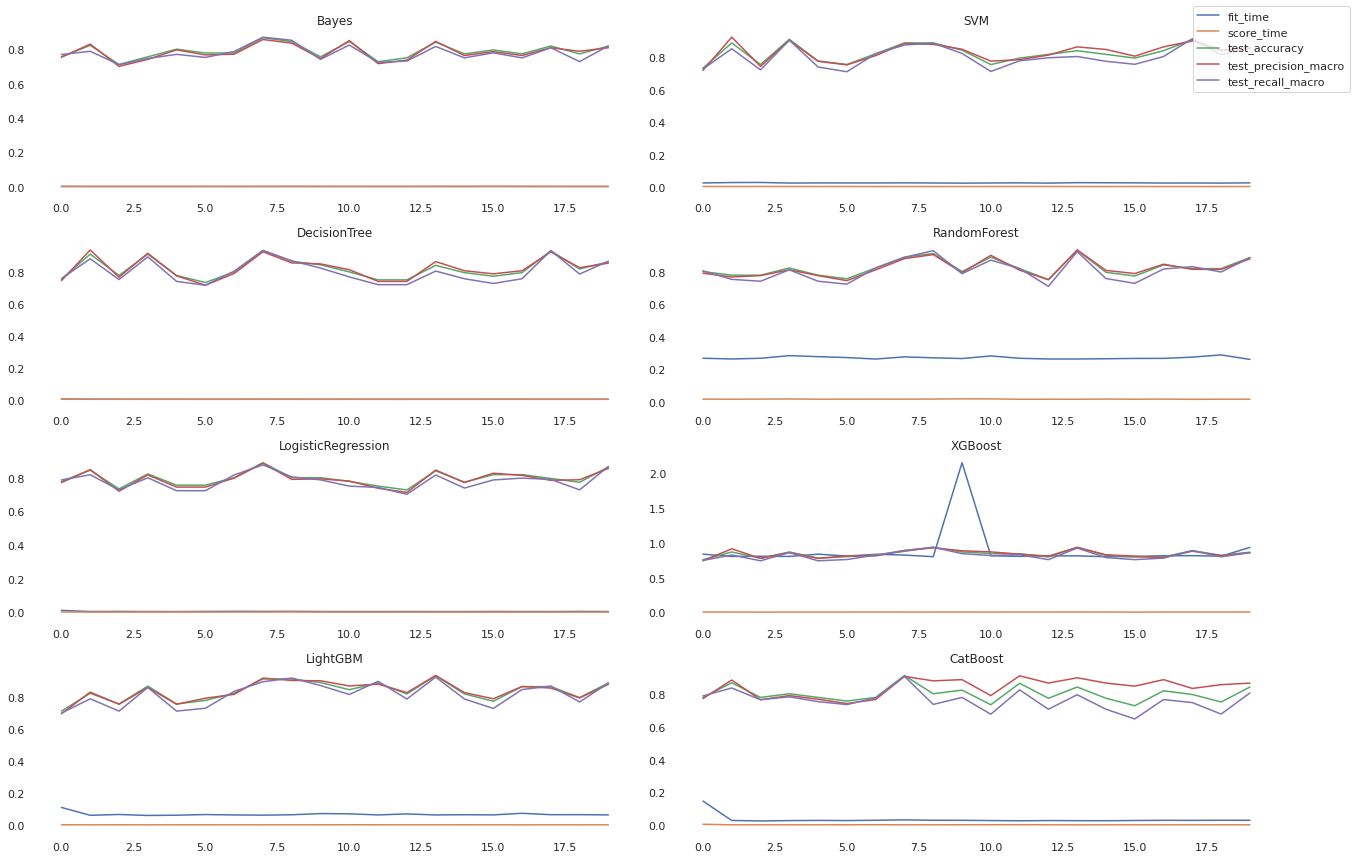

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,12))

for model in range(0, len(metrics_models)):
    name_model = list(metrics_models.keys())[model]
    plt.subplot(4, 2, model+1) # Uma figura com 3 linhas e 1 coluna
    plt.plot(pd.DataFrame(metrics_models[name_model]))
    plt.title(name_model)

fig.legend(list(metrics_models.values())[0].keys(), bbox_to_anchor=(1.05, 1), loc='upper right')

plt.tight_layout()  # Ajuste os espaços entre os subplots
plt.show()


In [26]:
metrics_df = pd.DataFrame(metrics_models).T.drop(columns={'fit_time', 'score_time'})
metrics_df.test_accuracy = metrics_df['test_accuracy'].apply(lambda x: np.mean(x))
metrics_df.test_precision_macro = metrics_df['test_precision_macro'].apply(lambda x: np.mean(x))
metrics_df.test_recall_macro = metrics_df['test_recall_macro'].apply(lambda x: np.mean(x))
metrics_df

,test_accuracy,test_precision_macro,test_recall_macro
Bayes,0.788965,0.782903,0.775547
SVM,0.827247,0.830622,0.804499
DecisionTree,0.821465,0.822381,0.800928
RandomForest,0.822702,0.819401,0.806610
LogisticRegression,0.795732,0.791172,0.778840
XGBoost,0.837273,0.839415,0.816301
LightGBM,0.835152,0.836280,0.815589
CatBoost,0.799091,0.837860,0.759594


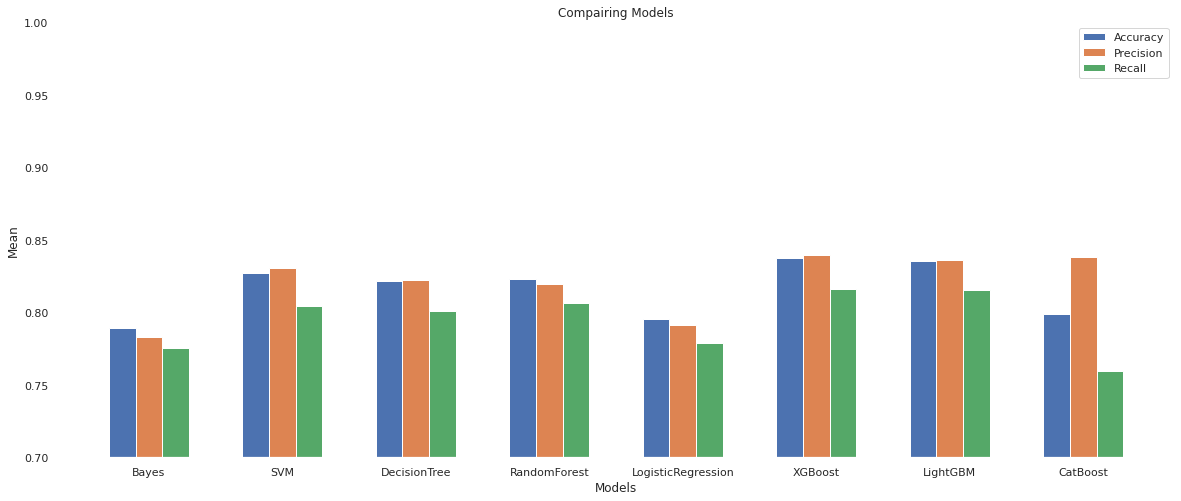

In [27]:
X = list(metrics_df.index)
accuracy = list(metrics_df.test_accuracy)
precision = list(metrics_df.test_precision_macro)
recall = list(metrics_df.test_recall_macro)

fig, ax = plt.subplots(figsize=(20, 8))

X_axis = np.arange(len(X))

ax.bar(X_axis - 0.2, accuracy, 0.2, label='Accuracy')
ax.bar(X_axis, precision, 0.2, label='Precision')
ax.bar(X_axis + 0.2, recall, 0.2, label='Recall')

ax.set_xticks(X_axis)
ax.set_xticklabels(X)
ax.set_ylim(0.7, 1.0)

ax.set_xlabel("Models")
ax.set_ylabel("Mean")
ax.set_title("Compairing Models")
ax.legend()

plt.show()

## Choosing the Model

In [28]:
test['SBin'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
testX, _ = data_preparation(test)
predictions = modelXGB.predict(testX)

In [29]:
df_predicted = pd.DataFrame(predictions).set_index(test['PassengerId'])
df_predicted

,0
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
